In [152]:
#!pip install google-cloud-aiplatform langchain
#!pip install openai
#!pip install pandas
#!pip install stringio
#!pip install nest_asyncio
#!pip install Pillow

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
/usr/share/python-wheels/urllib3-1.25.8-py2.py3-none-any.whl/urllib3/connectionpool.py:999: InsecureRequestWarning: Unverified HTTPS request is being made to host 'pypi.ngc.nvidia.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
     |████████████████████████████████| 3.5 MB 6.3 MB/s eta 0:00:01


In [1]:
# make psuedo user profiles - email, first name, last name, tel number, city

import pandas as pd
import numpy as np
import random
import string
import datetime
import time
import os
import sys
import csv
import json
import re
import math
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

def makePsuedoUserProfiles(numOfUser):
  print("Making psuedo user profiles...")
  df = pd.DataFrame(columns=['email', 'first_name', 'last_name', 'tel_number', 'city'])
  for i in range(numOfUser):
    df.loc[i] = [makeEmail(), makeFirstName(), makeLastName(), makeTelNumber(), makeCity()]
  return df

def makeEmail():
  return ''.join(random.choice(string.ascii_lowercase) for i in range(10)) + '@' + ''.join(random.choice(string.ascii_lowercase) for i in range(5)) + '.com'

  

In [140]:
import vertexai
from langchain.chat_models import ChatVertexAI
from langchain.llms import VertexAI
import os

PROJECT_ID = os.getenv("PROJECT_ID")  # @param {type:"string"}
vertexai.init(project=PROJECT_ID, location="us-central1")

llm_vertex = VertexAI(
    model_name="text-bison@latest",
    #model_name="text-bison-32k",
    max_output_tokens=2048,
    temperature=0,
    top_p=0.8,
    top_k=40,
)


In [113]:

def makePsuedoUserProfiles(numofUsers):
  return llm_vertex.predict("""분석 담당자 역활을 위하여, 임의로 사용자 정보 {numOfUsers}개를 생성해줘. csv 포멧으로 작성하되 - email, 이름, 전화번호, 시군구 - 정보를 포함하도록 해줘.
  예시 : user1@example.com,김철수,010-1234-5678,서울특별시 서초구
  """.format(numOfUsers=numofUsers))

In [114]:
profile_csv = makePsuedoUserProfiles(10)

In [125]:
def refineCSVString(csvString, default_item_num=4):
  lines = []
  for line in csvString.split('\n'):
    print(line)
    if len(line.split(',')) == default_item_num:
      lines.append(line)
  return lines


In [108]:
import pandas as pd
from io import StringIO

def readCSVStringToDataFrame(csvString):
  return pd.read_csv(StringIO(csvString)) 


In [116]:
user_profile_list = refineCSVString(profile_csv)

 ```
email,이름,전화번호,시군구
user1@example.com,김철수,010-1234-5678,서울특별시 서초구
user2@example.com,박영희,010-2345-6789,부산광역시 해운대구
user3@example.com,이민호,010-3456-7890,인천광역시 부평구
user4@example.com,김수지,010-4567-8901,대구광역시 동구
user5@example.com,박지민,010-5678-9012,광주광역시 서구
user6@example.com,이정현,010-6789-0123,대전광역시 유성구
user7@example.com,김태희,010-7890-1234,울산광역시 남구
user8@example.com,박상규,010-8901-2345,세종특별자치시
user9@example.com,이영애,010-9012-3456,제주특별자치도 제주시
user10@example.com,김연경,010-0123-4567,강원도 춘천시
```


In [117]:
from langchain.prompts import PromptTemplate

def rate_limit(max_per_minute):
  period = 60 / max_per_minute
  print("Waiting")
  while True:
      before = time.time()
      yield
      after = time.time()
      elapsed = after - before
      sleep_time = max(0, period - elapsed)
      if sleep_time > 0:
          print(".", end="")
          time.sleep(sleep_time)

def makeMarketingPhraseWithVertexLLM(user_profile):
  prompt = PromptTemplate.from_template("""As a marketing analysis role, make marketing phrases with user profile.
  User profile: email, first name, last name, tel number, city
  {user_profile}""")
  chain = prompt | llm_vertex
  return chain.invoke({"user_profile":user_profile})

def makeMarketingPhraseWithVertexLLMWithRateLimit(user_profile):
  rate_limit(50)
  return makeMarketingPhraseWithVertexLLM(user_profile)

for user_profile in user_profile_list:
  print(makeMarketingPhraseWithVertexLLM(user_profile))

 * "Get 10% off your first purchase when you sign up for our email list!"
* "We'll never share your information with third parties. Your privacy is our top priority."
* "We're here to help you find the perfect product for your needs. Just give us a call or send us an email and we'll be happy to assist you."
* "We're always running sales and promotions. Be sure to sign up for our email list to stay up-to-date on our latest offers!"
* "We offer free shipping on all orders over $50."
* "We have a satisfaction guarantee. If you're not happy with your purchase, simply return it for a full refund."
* "We're a family-owned and operated business. We take pride in our customer service and we're always happy to help you find what you're looking for."
* "We're committed to providing our customers with the best possible shopping experience. We hope you'll give us a try!"
 * "김철수님, 서울특별시 서초구에 거주하시고, 전화번호는 010-1234-5678이시군요. 이메일 주소는 user1@example.com이시죠?"
* "김철수님, 서울특별시 서초구에 거주하시고, 전화번호는 010-1234-56

In [119]:
def makeMarketingPhraseInCPGWithVertexLLM(user_profile):
  prompt = PromptTemplate.from_template("""당신은 음식 소매 마케팅 담당자로서, 다음과 같은 유저 프로파일을 가지고 있습니다. 이 사람에게 어떤 마케팅 문구를 제안하겠습니까?
  User profile: email, first name, last name, tel number, city
  {user_profile}""")
  chain = prompt | llm_vertex
  print(prompt.format(user_profile=user_profile))
  return chain.invoke({"user_profile":user_profile})


for user_profile in user_profile_list:
  print(user_profile)
  print(makeMarketingPhraseInCPGWithVertexLLM(user_profile))


email,이름,전화번호,시군구
당신은 음식 소매 마케팅 담당자로서, 다음과 같은 유저 프로파일을 가지고 있습니다. 이 사람에게 어떤 마케팅 문구를 제안하겠습니까?
  User profile: email, first name, last name, tel number, city
  email,이름,전화번호,시군구
 * **제목:** [이름]님, 음식 소매점에서 쇼핑하세요!
* **본문:**

안녕하세요, [이름]님.

음식 소매점에서 쇼핑하세요! 신선한 농산물, 고품질 육류 및 해산물, 다양한 식료품 등 다양한 제품을 제공합니다. 또한, 다양한 할인 및 프로모션을 제공하므로 저렴한 가격으로 쇼핑할 수 있습니다.

지금 바로 음식 소매점에 방문하여 쇼핑을 시작하세요!

* **행동 촉구:**

지금 바로 음식 소매점에 방문하여 쇼핑을 시작하세요!
user1@example.com,김철수,010-1234-5678,서울특별시 서초구
당신은 음식 소매 마케팅 담당자로서, 다음과 같은 유저 프로파일을 가지고 있습니다. 이 사람에게 어떤 마케팅 문구를 제안하겠습니까?
  User profile: email, first name, last name, tel number, city
  user1@example.com,김철수,010-1234-5678,서울특별시 서초구
 * "김철수님, 서울특별시 서초구에 있는 음식 소매점에 오신 것을 환영합니다! 저희는 신선한 농산물, 고기, 해산물, 유제품 등 다양한 제품을 제공합니다. 또한, 저희는 다양한 종류의 와인과 술을 제공합니다. 저희는 매주 특별 할인을 제공하므로, 저희 웹사이트나 소셜 미디어를 확인하십시오. 오늘 저희를 방문해 주셔서 감사합니다!"
* "김철수님, 서울특별시 서초구에 있는 음식 소매점에 오신 것을 환영합니다! 저희는 신선한 농산물, 고기, 해산물, 유제품 등 다양한 제품을 제공합니다. 또한, 저희는 다양한 종류의 와인과 술을 제공합니다. 저희는 매주 특별 할인을 제공하므로, 저희 웹사이트나 소셜 미디어를 확인하십시오

In [121]:
def makeMarketingPhraseInCPGWithVertexLLM2(user_profile):
  prompt = PromptTemplate.from_template("""당신은 국내 2위 소매 판매 회사 '참좋은빵' 마케팅 담당자입니다. 금번 캠페인에게 사용자별로 특별한 캐치프레이즈를 제공해야 합니다. 캐치프레이즈는 단순할 수록, 참신할 수록 좋습니다.
  캠페인 정보 :
   목표 : 신선 식품 코너가 추가되었음을 사용자에게 알리기
   추가된 : 신선 식품의 종류 - 채소류, 고기류
   사용자에게 줄 수 있는 incentive : 최대 10% 할인 쿠폰. 고기류를 구매하면 5% 할인 쿠폰을 추가로 제공

  사용자 정보 : 
  {user_profile}""")
  chain = prompt | llm_vertex
  return chain.invoke({"user_profile":user_profile})


for user_profile in user_profile_list[1:5]:
  print("--------------------------------------------------------------------------------------")
  print(user_profile)
  print("-- Generated --")
  print(makeMarketingPhraseInCPGWithVertexLLM2(user_profile))


--------------------------------------------------------------------------------------
user1@example.com,김철수,010-1234-5678,서울특별시 서초구
-- Generated --
 * 김철수님, 참좋은빵의 신선 식품 코너에서 신선한 채소와 고기를 만나보세요!
* 김철수님, 참좋은빵에서 고기류를 구매하시면 5% 할인 쿠폰을 드립니다!
* 김철수님, 참좋은빵의 신선 식품 코너에서 최대 10% 할인 쿠폰을 받으세요!
* 김철수님, 참좋은빵에서 신선한 채소와 고기를 만나보세요!
* 김철수님, 참좋은빵에서 고기류를 구매하시면 5% 할인 쿠폰을 드립니다!
--------------------------------------------------------------------------------------
user2@example.com,박영희,010-2345-6789,부산광역시 해운대구
-- Generated --
 * 박영희님, 참좋은빵에서 신선한 채소와 고기를 만나보세요!
* 박영희님, 참좋은빵에서 신선한 식품을 10% 할인된 가격으로 즐기세요!
* 박영희님, 참좋은빵에서 고기류를 구매하시면 5% 할인 쿠폰을 추가로 드려요!
* 박영희님, 참좋은빵에서 신선한 식품을 즐기며 건강한 삶을 만드세요!
* 박영희님, 참좋은빵에서 신선한 식품을 맛보고 즐거운 하루 보내세요!
--------------------------------------------------------------------------------------
user3@example.com,이민호,010-3456-7890,인천광역시 부평구
-- Generated --
 * 이민호님, 참좋은빵에서 신선한 채소와 고기를 만나보세요!
* 이민호님, 참좋은빵에서 신선한 식품을 즐기세요!
* 이민호님, 참좋은빵에서 신선한 식품을 만나보세요!
* 이민호님, 참좋은빵에서 신선한 식품을 즐기세요!
* 이민호님, 참좋은빵에서 신선한 

In [122]:
def suggestConsumerGoods():
  prompt = """소매 상품 목록 10개를 생성해 주세요. (csv format)
  예 : 사과 1kg, 1500
  """
  return llm_vertex.predict(prompt)

products_list_str = suggestConsumerGoods()



In [123]:
products_list_str

' 품목,가격\n사과 1kg,1500\n바나나 1kg,2000\n포도 1kg,3000\n딸기 1kg,4000\n복숭아 1kg,5000\n배 1kg,6000\n수박 1kg,7000\n참외 1kg,8000\n키위 1kg,9000\n망고 1kg,10000'

In [126]:
df_products = readCSVStringToDataFrame('\n'.join(refineCSVString(products_list_str,2)))

 품목,가격
사과 1kg,1500
바나나 1kg,2000
포도 1kg,3000
딸기 1kg,4000
복숭아 1kg,5000
배 1kg,6000
수박 1kg,7000
참외 1kg,8000
키위 1kg,9000
망고 1kg,10000


In [127]:
df_products

,품목,가격
0,사과 1kg,1500
1,바나나 1kg,2000
2,포도 1kg,3000
3,딸기 1kg,4000
4,복숭아 1kg,5000
5,배 1kg,6000
6,수박 1kg,7000
7,참외 1kg,8000
8,키위 1kg,9000
9,망고 1kg,10000


In [128]:
def makePsuedoOrderProfiles(products_list_str, user_profile_str):
  print("Making psuedo order profiles...")
  prompt = """Make psuedo orders (randomly from 0 to 10 orders) with the given CPG items and a user profile in csv format.
  consumer goods information :
  {products_list_str}

  user profile :
  {user_profile}

  order information : 품목, 가격, 수량, 전체금액, 구매일자
  """
  return llm_vertex.predict(prompt.format(products_list_str=products_list_str, user_profile=user_profile_str))

In [129]:

def makeMarketingPhraseWithOrderAndUserProfile(user_profile, order_profile):
  prompt = PromptTemplate.from_template("""당신은 음식 소매 마케팅 담당자로서, 다음과 같은 사용자 프로파일과 해당 사용자가 구매한 내역을 가지고 있습니다. 이 사람에게 가을 추석 이벤트를 위한 마케팅 문구를 간단하게 적어주세요.
  User profile: email, first name, last name, tel number, city
  {user_profile}

  Orders : item, unit_price, quantity, total_price, order_date
  {order_profile}""")
  chain = prompt | llm_vertex
  print(prompt.format(user_profile=user_profile,order_profile=order_profile))
  return chain.invoke({"user_profile":user_profile, "order_profile":order_profile})



In [132]:
products_list_str

' 품목,가격\n사과 1kg,1500\n바나나 1kg,2000\n포도 1kg,3000\n딸기 1kg,4000\n복숭아 1kg,5000\n배 1kg,6000\n수박 1kg,7000\n참외 1kg,8000\n키위 1kg,9000\n망고 1kg,10000'

In [130]:
user_profile_str = user_profile_list[1]


In [141]:
psuedo_orders = makePsuedoOrderProfiles(products_list_str=products_list_str, user_profile_str=user_profile_str)

print(makeMarketingPhraseWithOrderAndUserProfile(user_profile=user_profile_str, order_profile=psuedo_orders))

Making psuedo order profiles...
당신은 음식 소매 마케팅 담당자로서, 다음과 같은 사용자 프로파일과 해당 사용자가 구매한 내역을 가지고 있습니다. 이 사람에게 가을 추석 이벤트를 위한 마케팅 문구를 간단하게 적어주세요.
  User profile: email, first name, last name, tel number, city
  user1@example.com,김철수,010-1234-5678,서울특별시 서초구

  Orders : item, unit_price, quantity, total_price, order_date
   ```
user1@example.com,김철수,010-1234-5678,서울특별시 서초구,사과 1kg,1500,1,1500,2023-03-08
user1@example.com,김철수,010-1234-5678,서울특별시 서초구,바나나 1kg,2000,2,4000,2023-03-08
user1@example.com,김철수,010-1234-5678,서울특별시 서초구,포도 1kg,3000,3,9000,2023-03-08
user1@example.com,김철수,010-1234-5678,서울특별시 서초구,딸기 1kg,4000,4,16000,2023-03-08
user1@example.com,김철수,010-1234-5678,서울특별시 서초구,복숭아 1kg,5000,5,25000,2023-03-08
user1@example.com,김철수,010-1234-5678,서울특별시 서초구,배 1kg,6000,6,36000,2023-03-08
user1@example.com,김철수,010-1234-5678,서울특별시 서초구,수박 1kg,7000,7,49000,2023-03-08
user1@example.com,김철수,010-1234-5678,서울특별시 서초구,참외 1kg,8000,8,64000,2023-03-08
user1@example.com,김철수,010-1234-5678,서울특별시 서초구,키위 1kg,9000,9,81000,2

In [149]:

def makeMarketingPhraseWithOrderAndUserProfile2(user_profile, order_profile):
  prompt = PromptTemplate.from_template("""당신은 음식 소매 회사 - 참좋은빵 - 마케팅 담당자로서, 이 사람에게 신규 캠페인를 위한 마케팅 문구를 간단하고 창의적인 문장으로 적어주세요. 다음과 같은 사용자 프로파일과 해당 사용자가 구매한 내역을 가지고 있습니다. 최대한 해당 정보를 활용해주세요.
  캠페인 정보 :
   목표 : 신선 식품 코너가 추가되었음을 사용자에게 알리고 기존 구매자들에게는 기존 구매 유도
   추가된 : 신선 식품의 종류 - 채소류, 고기류
   사용자에게 줄 수 있는 incentive : 최대 10% 할인 쿠폰. 고기류를 구매하면 5% 할인 쿠폰을 추가로 제공

  사용자 정보 :
  {user_profile}

  구매 이력 :
  {order_profile}""")
  chain = prompt | llm_vertex
  print(prompt.format(user_profile=user_profile,order_profile=order_profile))
  return chain.invoke({"user_profile":user_profile, "order_profile":order_profile})



In [150]:
print(makeMarketingPhraseWithOrderAndUserProfile2(user_profile=user_profile_str, order_profile=psuedo_orders))

당신은 음식 소매 회사 - 참좋은빵 - 마케팅 담당자로서, 이 사람에게 신규 캠페인를 위한 마케팅 문구를 간단하고 창의적인 문장으로 적어주세요. 다음과 같은 사용자 프로파일과 해당 사용자가 구매한 내역을 가지고 있습니다. 최대한 해당 정보를 활용해주세요.
  캠페인 정보 :
   목표 : 신선 식품 코너가 추가되었음을 사용자에게 알리고 기존 구매자들에게는 기존 구매 유도
   추가된 : 신선 식품의 종류 - 채소류, 고기류
   사용자에게 줄 수 있는 incentive : 최대 10% 할인 쿠폰. 고기류를 구매하면 5% 할인 쿠폰을 추가로 제공

  사용자 정보 :
  user1@example.com,김철수,010-1234-5678,서울특별시 서초구

  구매 이력 :
   ```
user1@example.com,김철수,010-1234-5678,서울특별시 서초구,사과 1kg,1500,1,1500,2023-03-08
user1@example.com,김철수,010-1234-5678,서울특별시 서초구,바나나 1kg,2000,2,4000,2023-03-08
user1@example.com,김철수,010-1234-5678,서울특별시 서초구,포도 1kg,3000,3,9000,2023-03-08
user1@example.com,김철수,010-1234-5678,서울특별시 서초구,딸기 1kg,4000,4,16000,2023-03-08
user1@example.com,김철수,010-1234-5678,서울특별시 서초구,복숭아 1kg,5000,5,25000,2023-03-08
user1@example.com,김철수,010-1234-5678,서울특별시 서초구,배 1kg,6000,6,36000,2023-03-08
user1@example.com,김철수,010-1234-5678,서울특별시 서초구,수박 1kg,7000,7,49000,2023-03-08
user1@example.com,김철수,010-1234-5678,서울특별시 서초구,참외 1kg,8000,8,64000,2023-03-08


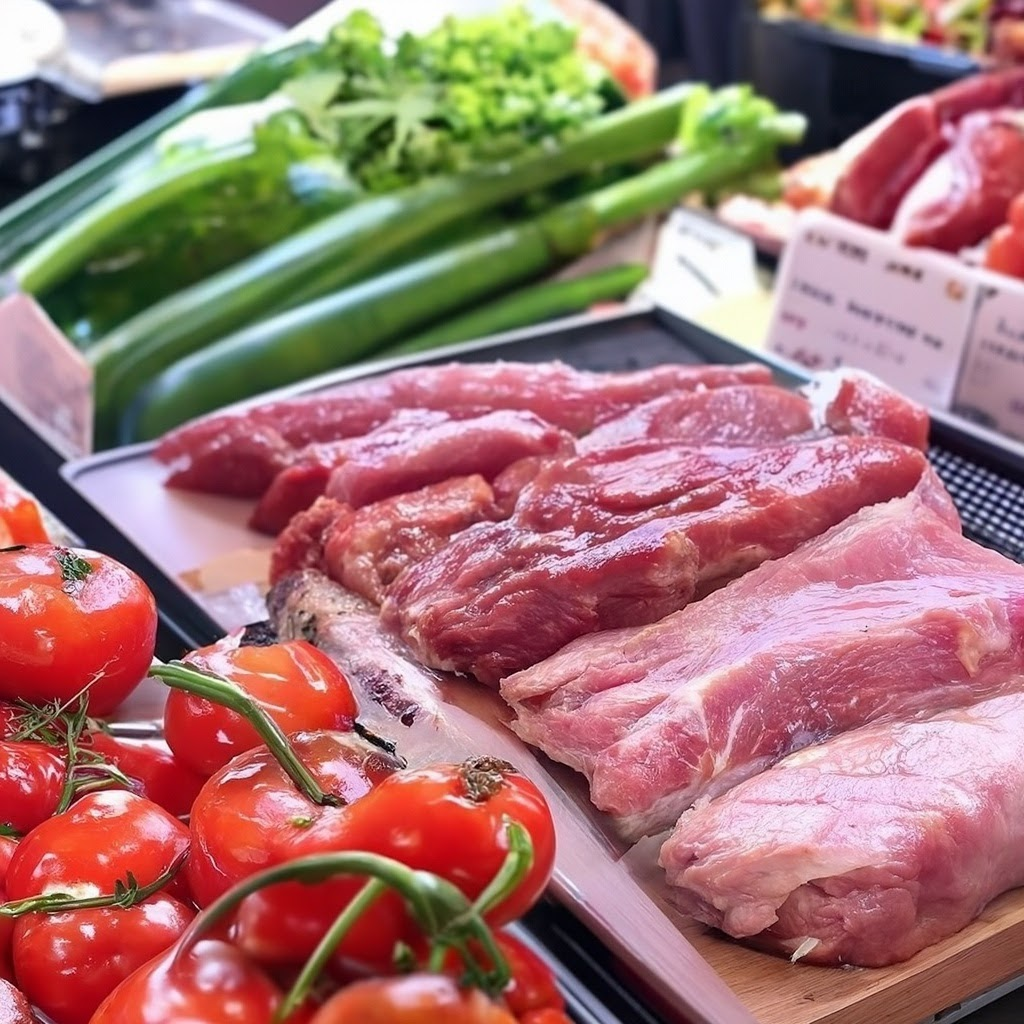

In [3]:
from vertexai.preview.vision_models import ImageGenerationModel

imagemodel = ImageGenerationModel.from_pretrained("imagegeneration@002")
response = imagemodel.generate_images(
    prompt="""**"Good Bread" company Fresh Food Corner Open!**
**Vegetables and meat are sold at up to 10% discount**.
**If you purchase meat, you will receive an additional 5% discount coupon**.
**Check out fresh food at Chamjounbread right now!**""",
    # Optional:
    number_of_images=1,
    seed=0,
)
response[0].show()
response[0].save("image1.png")